In [104]:
import sys
sys.path.append("..")

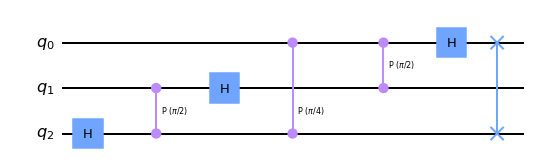

In [105]:
from qiskit import transpile
from qiskit.converters import circuit_to_dag, dag_to_circuit
from circuit_suite import circuits
circuit_label="QFT"
qsize =3
qc = transpile(circuits[circuit_label].circuit_lambda(qsize)).decompose()
qc.draw(output='mpl')

In [106]:
# from qiskit import transpile
# from qiskit.converters import circuit_to_dag, dag_to_circuit
# from circuit_suite import circuits
# circuit_label="QFT"
# c = transpile(circuits[circuit_label].circuit_lambda(qsize), basis_gates=['u', 'cx'])
# c.draw(output='mpl')

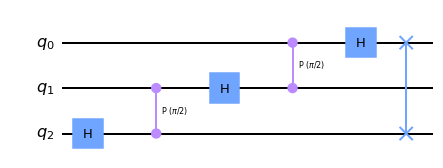

In [107]:
dag = circuit_to_dag(qc)
def weight_fn(source_node, target_node, weight):
    if dag._multi_graph[source_node].name is None:
        return 0
    else:
        return 1
import retworkx
longest_path = retworkx.dag_longest_path(dag._multi_graph, weight_fn=weight_fn)
dlp = [
    dag._multi_graph[index] for index in longest_path
]
for node in dag.op_nodes():
    if not node in dlp:
        dag.remove_op_node(node)
qc_t = dag_to_circuit(dag)
qc_t.draw(output='mpl')

In [108]:
x = [qsize]
y = [circuit_to_dag(transpile(circuits[circuit_label].circuit_lambda(xi), basis_gates=['u', 'cx'])).count_ops_longest_path()['cx'] for xi in x]
z = [circuit_to_dag(transpile(circuits[circuit_label].circuit_lambda(xi), basis_gates=['u', 'cx'])).count_ops()['cx'] for xi in x]
print(y, z)

[9] [9]


In [109]:
import numpy as np
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector

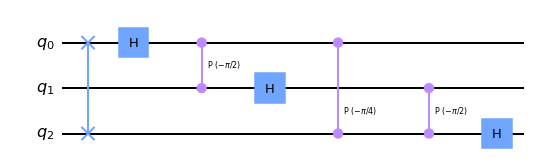

In [110]:
from qiskit.circuit.library.basis_change import QFT
inverse_qft_lambda = lambda q: QFT(q, inverse=True)
qc = inverse_qft_lambda(qsize)
qc.decompose().draw(output='mpl')

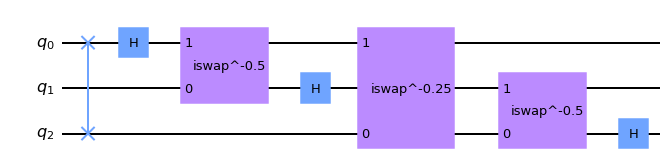

In [111]:
#replace every R_z with a Riswap?
#can e made a transformation pass if wanted to
from qiskit.circuit.library.standard_gates import iSwapGate
from utils.riswap_gates.riswap import RiSwapGate
dag = circuit_to_dag(qc.decompose())
for node in dag.op_nodes():
    #if we hit a Rz gate then replace it 
    if node.op.name in ["cp"]:
        #get the rotation angle
        angle = node.op.params[0]

        replacement = QuantumCircuit(2)
        #replacement.append(RiSwapGate(angle/np.pi), [0,1])
        replacement.append(iSwapGate().power(angle/np.pi), [0,1])
        
        #replacement.draw(output='mpl')
        dag.substitute_node_with_dag(node, circuit_to_dag(replacement))

        # print(angle)
qc_modified = dag_to_circuit(dag)
qc_modified.draw(output='mpl')

In [112]:
nqubits = 3
number = 3
prep = QuantumCircuit(qsize)
for qubit in range(qsize):
    prep.h(qubit)
prep.p(number*pi/4,0)
prep.p(number*pi/2,1)
prep.p(number*pi,2)

prep.draw()

┌───┐┌─────────┐
q_0: ┤ H ├┤ P(3π/4) ├
     ├───┤├─────────┤
q_1: ┤ H ├┤ P(3π/2) ├
     ├───┤└┬───────┬┘
q_2: ┤ H ├─┤ P(3π) ├─
     └───┘ └───────┘

/tmp/ipykernel_611837/2052485945.py:1: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  qc = prep + qc_modified


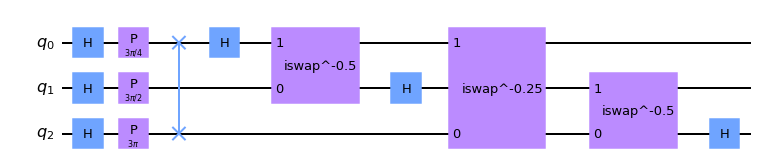

In [113]:
qc = prep + qc_modified
qc.draw(output='mpl')

In [117]:
#now simulate the qft to get a histogram
backend = sim = Aer.get_backend("aer_simulator")
qc.measure_all()
transpiled_qc = transpile(qc, backend, optimization_level=3, basis_gates=['u', 'cx'])
job = backend.run(transpiled_qc, shots=1000)
job_monitor(job)

Job Status: job has successfully run


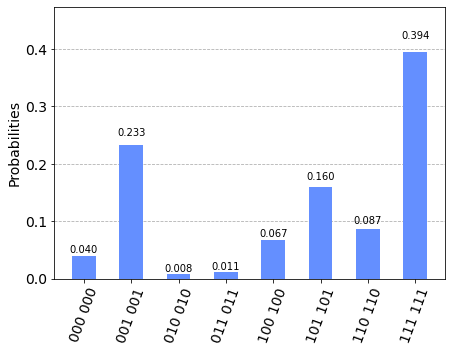

In [119]:
counts = job.result().get_counts()
plot_histogram(counts)